# PyGGM: Gaussian Graphical Models in Python

PyGGM is a Python package for learning **Gaussian Graphical Models (GGMs)** from data. GGMs represent conditional independence relationships between variables as a graph:

- **Nodes** = Variables
- **Edges** = Direct relationships (conditional dependencies)
- **No edge** = Conditional independence

## Table of Contents
1. [Simulated Network Examples](#simulated)
   - Hub Network
   - Chain Network
   - Random Network
   - Block Diagonal Network
   - Scale-Free Network

2. [Regularization Path Visualization](#regpath)

In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
import warnings
import time
import pickle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
warnings.filterwarnings('ignore')

# Import PyGGM
from pyggm import GaussianGraphicalModel, Nonparanormal
from pyggm.visualization import (
    plot_network,
    plot_precision_matrix,
    plot_stars_path,
    plot_regularization_path
)

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("PyGGM loaded successfully!")

PyGGM loaded successfully!


<a id='simulated'></a>
## Simulated Network Examples

We'll test PyGGM on networks with **known ground truth** to validate its performance.

### Helper Functions

In [2]:
def evaluate_recovery(true_adj, estimated_adj):
    """
    Evaluate network recovery performance.
    
    Returns:
        precision, recall, f1_score
    """
    # Get upper triangle (undirected graph)
    mask = np.triu(np.ones_like(true_adj, dtype=bool), k=1)
    
    true_edges = true_adj[mask]
    est_edges = estimated_adj[mask]
    
    # True/False positives/negatives
    tp = np.sum((true_edges == 1) & (est_edges == 1))
    fp = np.sum((true_edges == 0) & (est_edges == 1))
    fn = np.sum((true_edges == 1) & (est_edges == 0))
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def plot_comparison(true_adj, estimated_adj, true_theta, est_theta, title, labels=None, custom_pos=None):
    """
    Plot ground truth vs estimated network side-by-side.
    
    Parameters:
    -----------
    custom_pos : dict, optional
        Custom node positions for network visualization.
        If None, spring layout will be used.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # True adjacency
    axes[0, 0].imshow(true_adj, cmap='Greys', vmin=0, vmax=1)
    axes[0, 0].set_title('Ground Truth Adjacency', fontweight='bold')
    if labels:
        axes[0, 0].set_xticks(range(len(labels)))
        axes[0, 0].set_yticks(range(len(labels)))
        axes[0, 0].set_xticklabels(labels, rotation=90, fontsize=8)
        axes[0, 0].set_yticklabels(labels, fontsize=8)
    
    # Estimated adjacency
    axes[0, 1].imshow(estimated_adj, cmap='Greys', vmin=0, vmax=1)
    axes[0, 1].set_title('Estimated Adjacency', fontweight='bold')
    if labels:
        axes[0, 1].set_xticks(range(len(labels)))
        axes[0, 1].set_yticks(range(len(labels)))
        axes[0, 1].set_xticklabels(labels, rotation=90, fontsize=8)
        axes[0, 1].set_yticklabels(labels, fontsize=8)
    
    # True network - custom layout if provided
    if custom_pos is not None:
        # Build graph from true_theta
        G_true = nx.Graph()
        p = true_theta.shape[0]
        G_true.add_nodes_from(range(p))
        for i in range(p):
            for j in range(i+1, p):
                if np.abs(true_theta[i, j]) > 0.01:
                    G_true.add_edge(i, j)
        
        axes[1, 0].clear()
        nx.draw_networkx_nodes(G_true, custom_pos, node_size=400,
                             node_color='lightgreen', edgecolors='black',
                             linewidths=2, ax=axes[1, 0])
        nx.draw_networkx_edges(G_true, custom_pos, width=2, alpha=0.5, ax=axes[1, 0])
        nx.draw_networkx_labels(G_true, custom_pos, font_size=9, font_weight='bold', ax=axes[1, 0])
        axes[1, 0].set_title('Ground Truth Network', fontweight='bold')
        axes[1, 0].axis('off')
    else:
        plot_network(true_theta, threshold=0.01, layout='spring', 
                    labels=labels, ax=axes[1, 0])
        axes[1, 0].set_title('Ground Truth Network', fontweight='bold')
    
    # Estimated network - custom layout if provided
    if custom_pos is not None:
        # Build graph from est_theta
        G_est = nx.Graph()
        p = est_theta.shape[0]
        G_est.add_nodes_from(range(p))
        for i in range(p):
            for j in range(i+1, p):
                if np.abs(est_theta[i, j]) > 0.01:
                    G_est.add_edge(i, j)
        
        axes[1, 1].clear()
        nx.draw_networkx_nodes(G_est, custom_pos, node_size=400,
                             node_color='lightblue', edgecolors='black',
                             linewidths=2, ax=axes[1, 1])
        nx.draw_networkx_edges(G_est, custom_pos, width=2, alpha=0.5, ax=axes[1, 1])
        nx.draw_networkx_labels(G_est, custom_pos, font_size=9, font_weight='bold', ax=axes[1, 1])
        axes[1, 1].set_title('Estimated Network', fontweight='bold')
        axes[1, 1].axis('off')
    else:
        plot_network(est_theta, threshold=0.01, layout='spring',
                    labels=labels, ax=axes[1, 1])
        axes[1, 1].set_title('Estimated Network', fontweight='bold')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 4.1 Hub Network

**Structure**: One central hub connected to many nodes

**Use case**: Gene regulatory networks, protein interaction networks

Hub Network Recovery
True edges:      10
Estimated edges: 12
Precision:       0.833
Recall:          1.000
F1-Score:        0.909


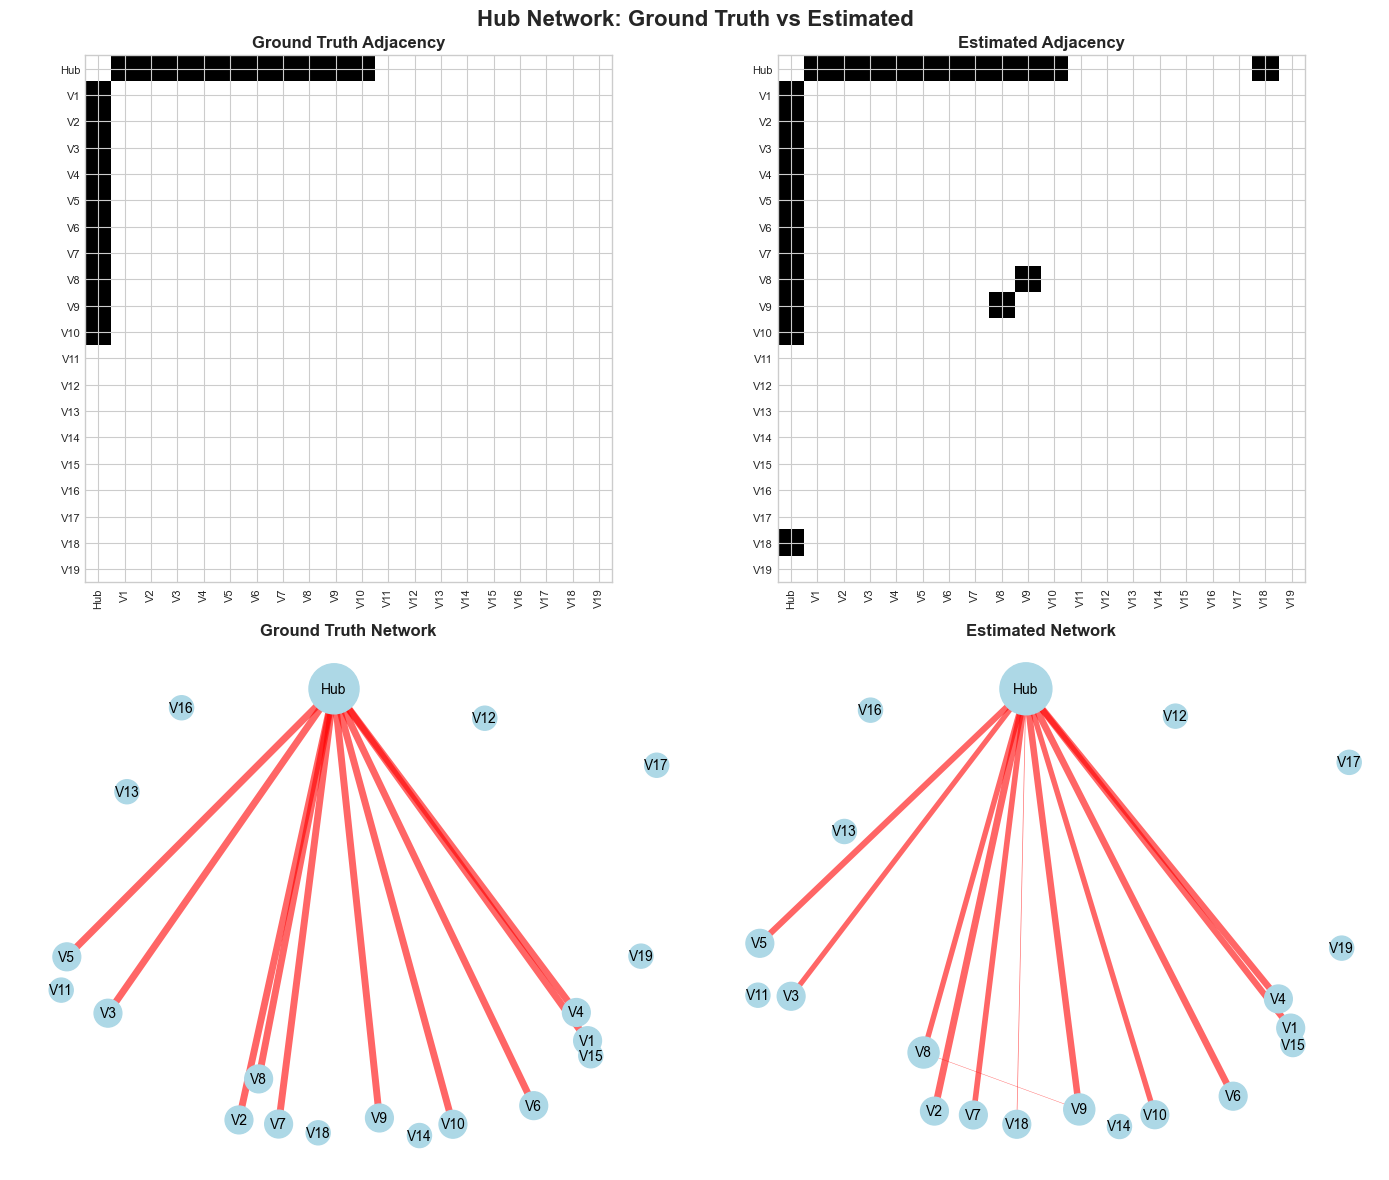

In [17]:
def generate_hub_network(n_samples=500, p=20, hub_size=10, edge_strength=0.5):
    """
    Generate hub network: node 0 is connected to first hub_size nodes.
    """
    # Create precision matrix (inverse covariance)
    Theta = np.eye(p) * 2.0  # Diagonal dominance
    
    # Add hub connections
    for i in range(1, hub_size + 1):
        Theta[0, i] = -edge_strength
        Theta[i, 0] = -edge_strength
    
    # Ensure positive definite
    min_eig = np.min(np.linalg.eigvalsh(Theta))
    if min_eig < 0.1:
        Theta += np.eye(p) * (0.1 - min_eig)
    
    # Generate data
    Sigma = np.linalg.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_samples)
    
    # True adjacency
    adjacency = (np.abs(Theta) > 1e-6).astype(int)
    np.fill_diagonal(adjacency, 0)
    
    return X, Theta, adjacency

# Generate hub network
X_hub, Theta_hub, adj_hub = generate_hub_network(n_samples=500, p=20, hub_size=10)

# Fit PyGGM
model_hub = GaussianGraphicalModel(method='ebic', gamma=0.0)  
model_hub.fit(X_hub)

# Evaluate
precision, recall, f1 = evaluate_recovery(adj_hub, model_hub.adjacency_)

print("Hub Network Recovery")
print("=" * 50)
print(f"True edges:      {adj_hub.sum() // 2}")
print(f"Estimated edges: {model_hub.n_edges_}")
print(f"Precision:       {precision:.3f}")
print(f"Recall:          {recall:.3f}")
print(f"F1-Score:        {f1:.3f}")
print("=" * 50)

# Visualize
labels = [f'Hub' if i == 0 else f'V{i}' for i in range(20)]
plot_comparison(adj_hub, model_hub.adjacency_, Theta_hub, model_hub.precision_,
               'Hub Network: Ground Truth vs Estimated', labels=labels)

### 4.2 Chain Network

**Structure**: Variables connected in a sequence (1→2→3→...→p)

**Use case**: Time series, sequential processes

Chain Network Recovery
True edges:      14
Estimated edges: 14
Precision:       1.000
Recall:          1.000
F1-Score:        1.000


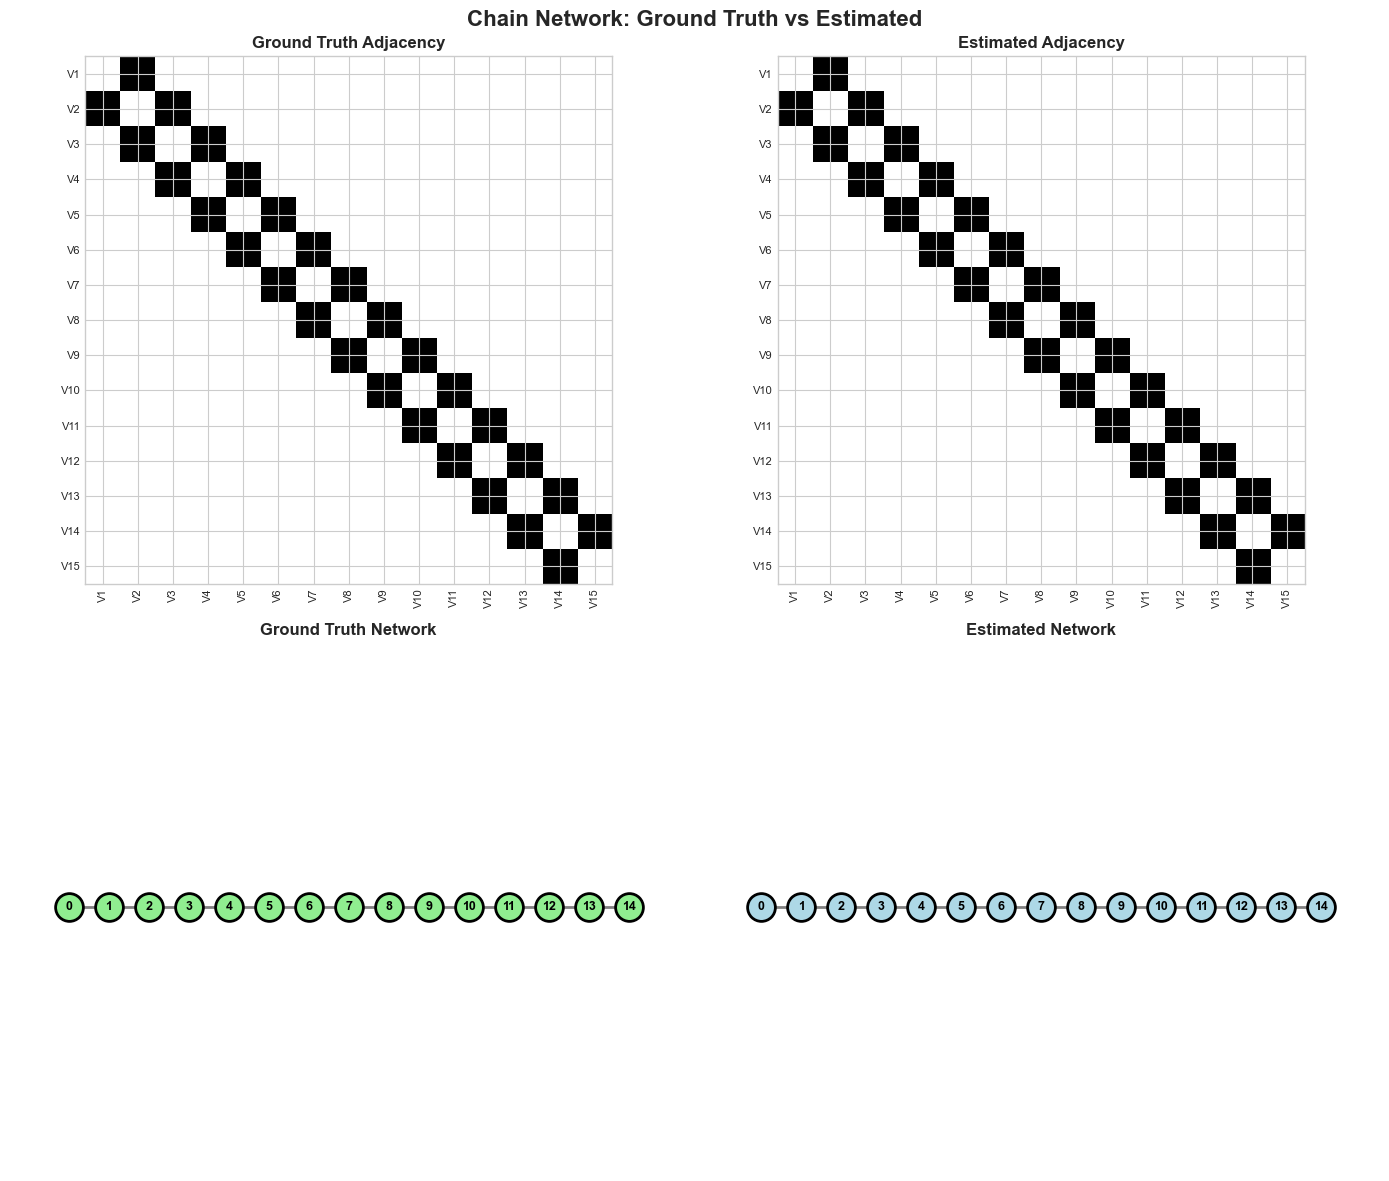

In [18]:
def generate_chain_network(n_samples=500, p=15, edge_strength=0.6):
    """
    Generate chain network: nodes connected sequentially.
    """
    Theta = np.eye(p) * 2.0
    
    # Add chain connections
    for i in range(p - 1):
        Theta[i, i + 1] = -edge_strength
        Theta[i + 1, i] = -edge_strength
    
    # Generate data
    Sigma = np.linalg.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_samples)
    
    adjacency = (np.abs(Theta) > 1e-6).astype(int)
    np.fill_diagonal(adjacency, 0)
    
    return X, Theta, adjacency

# Generate and fit
X_chain, Theta_chain, adj_chain = generate_chain_network()

model_chain = GaussianGraphicalModel(method='stars', beta=0.05)
model_chain.fit(X_chain)

# Evaluate
precision, recall, f1 = evaluate_recovery(adj_chain, model_chain.adjacency_)

print("Chain Network Recovery")
print("=" * 50)
print(f"True edges:      {adj_chain.sum() // 2}")
print(f"Estimated edges: {model_chain.n_edges_}")
print(f"Precision:       {precision:.3f}")
print(f"Recall:          {recall:.3f}")
print(f"F1-Score:        {f1:.3f}")
print("=" * 50)

# Use LINEAR layout for chain - this makes the structure clear!
labels = [f'V{i+1}' for i in range(15)]
pos_chain = {i: (i, 0) for i in range(15)}  # Horizontal line

plot_comparison(adj_chain, model_chain.adjacency_, Theta_chain, model_chain.precision_,
               'Chain Network: Ground Truth vs Estimated', labels=labels, custom_pos=pos_chain)

### 4.3 Random (Erdős-Rényi) Network

**Structure**: Edges added randomly with probability p

**Use case**: Testing robustness, general networks

Random Network Recovery
True edges:      12
Estimated edges: 48
Precision:       0.250
Recall:          1.000
F1-Score:        0.400


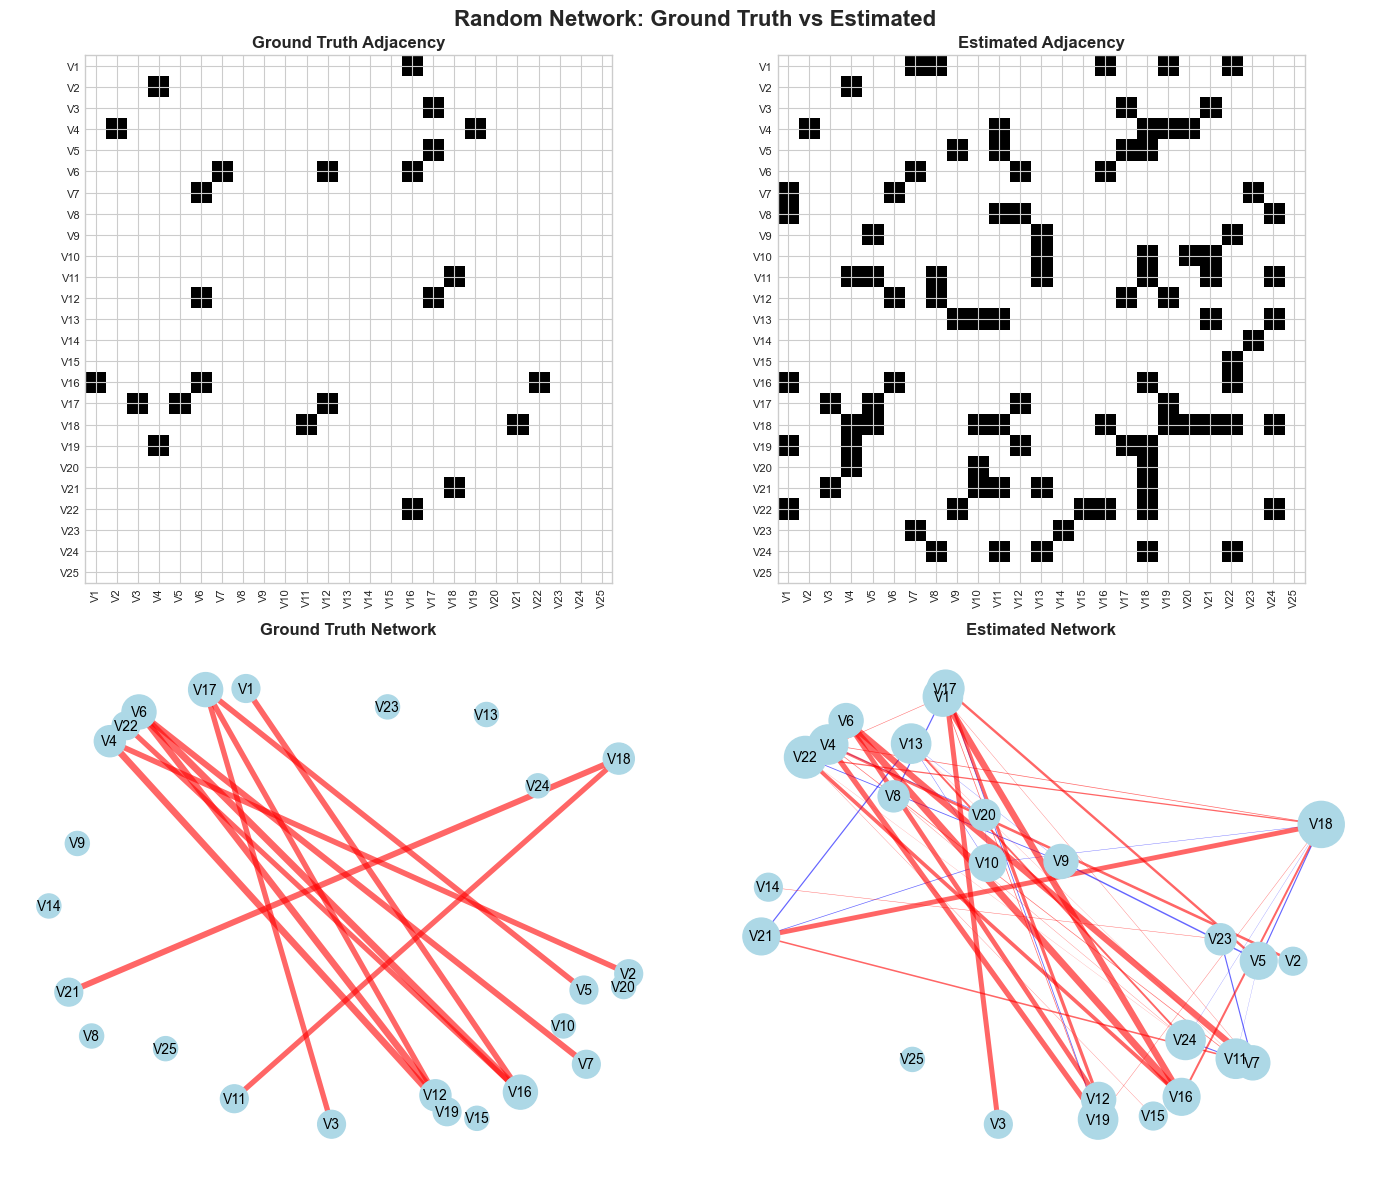

In [19]:
def generate_random_network(n_samples=500, p=25, edge_prob=0.05):
    """
    Generate random Erdős-Rényi network.
    """
    Theta = np.eye(p) * 2.0
    
    # Add random edges
    for i in range(p):
        for j in range(i + 1, p):
            if np.random.rand() < edge_prob:
                strength = np.random.uniform(-0.5, -0.3)
                Theta[i, j] = strength
                Theta[j, i] = strength
    
    # Ensure positive definite
    min_eig = np.min(np.linalg.eigvalsh(Theta))
    if min_eig < 0.1:
        Theta += np.eye(p) * (0.1 - min_eig)
    
    Sigma = np.linalg.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_samples)
    
    adjacency = (np.abs(Theta) > 1e-6).astype(int)
    np.fill_diagonal(adjacency, 0)
    
    return X, Theta, adjacency

# Generate and fit
X_random, Theta_random, adj_random = generate_random_network()

model_random = GaussianGraphicalModel(method='cv', cv=5)
model_random.fit(X_random)

# Evaluate
precision, recall, f1 = evaluate_recovery(adj_random, model_random.adjacency_)

print("Random Network Recovery")
print("=" * 50)
print(f"True edges:      {adj_random.sum() // 2}")
print(f"Estimated edges: {model_random.n_edges_}")
print(f"Precision:       {precision:.3f}")
print(f"Recall:          {recall:.3f}")
print(f"F1-Score:        {f1:.3f}")
print("=" * 50)

labels = [f'V{i+1}' for i in range(25)]
plot_comparison(adj_random, model_random.adjacency_, Theta_random, model_random.precision_,
               'Random Network: Ground Truth vs Estimated', labels=labels)

### 4.4 Block Diagonal Network

**Structure**: Variables organized into communities with dense within-block connections

**Use case**: Community detection, modular systems

Block Diagonal Network Recovery
Structure: 4 blocks of 5 nodes
True edges:      25
Estimated edges: 20
Precision:       0.950
Recall:          0.760
F1-Score:        0.844


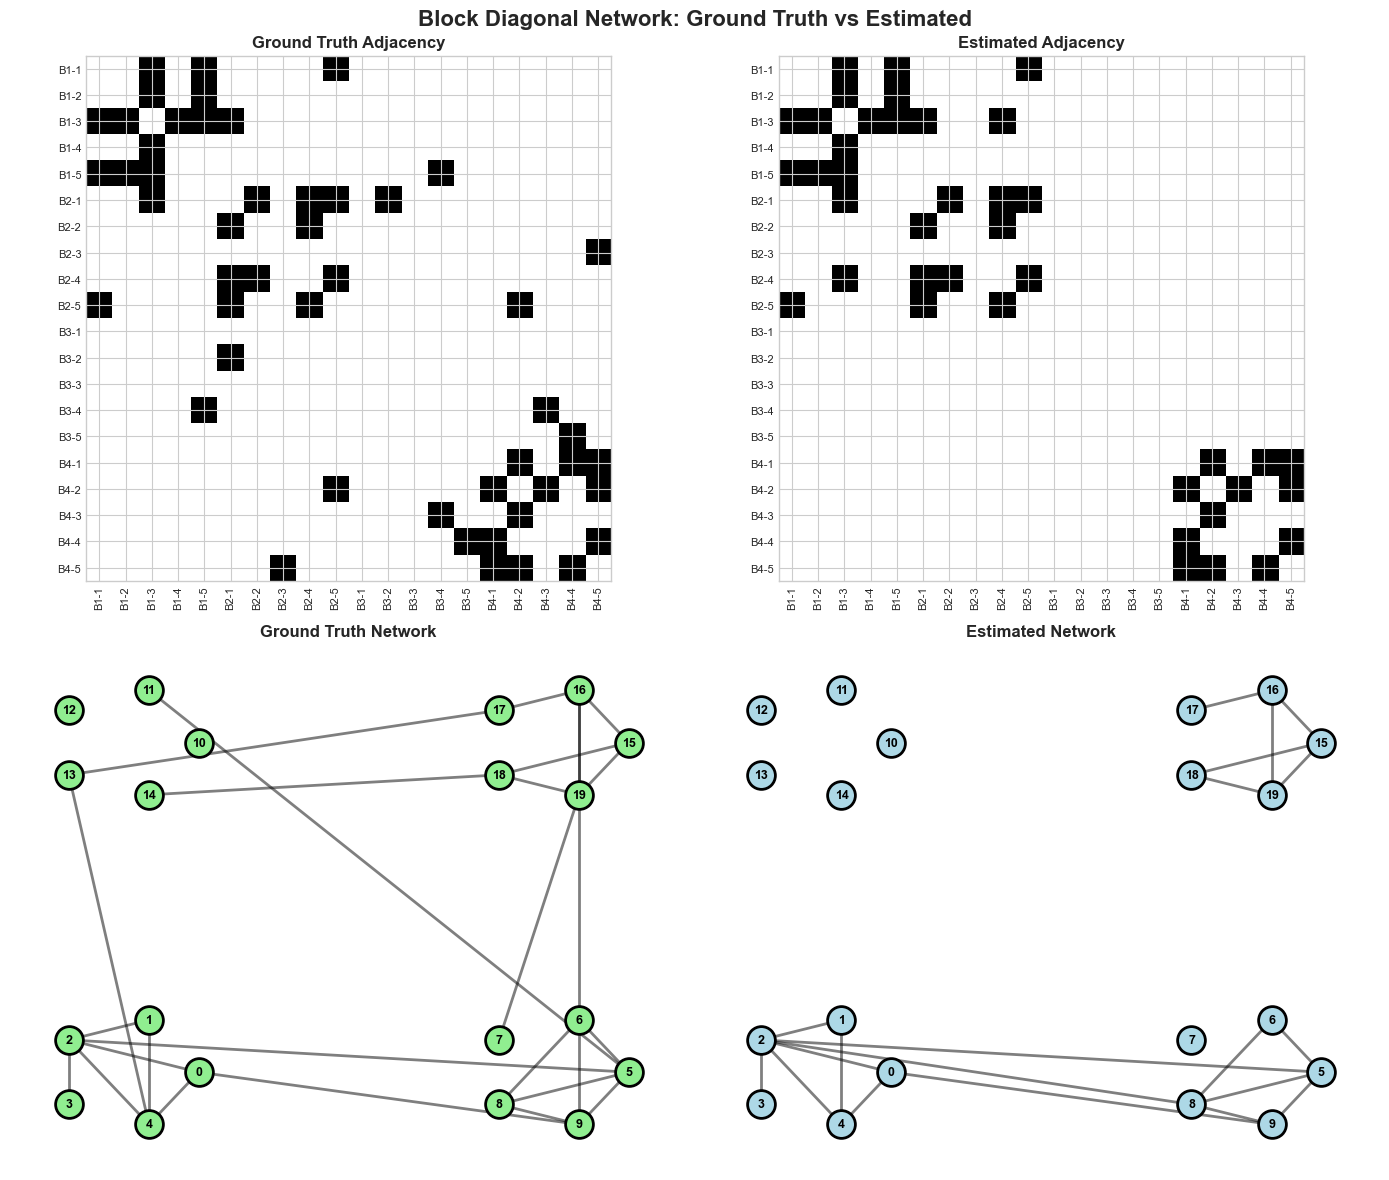

In [22]:
def generate_block_network(n_samples=500, n_blocks=4, block_size=5, 
                          within_prob=0.5, between_prob=0.05):
    """
    Generate block diagonal network with communities.
    """
    p = n_blocks * block_size
    Theta = np.eye(p) * 2.0
    
    for block in range(n_blocks):
        start = block * block_size
        end = (block + 1) * block_size
        
        # Within-block connections (dense)
        for i in range(start, end):
            for j in range(i + 1, end):
                if np.random.rand() < within_prob:
                    strength = np.random.uniform(-0.6, -0.4)
                    Theta[i, j] = strength
                    Theta[j, i] = strength
    
    # Between-block connections (sparse)
    for i in range(p):
        for j in range(i + 1, p):
            if i // block_size != j // block_size:  # Different blocks
                if np.random.rand() < between_prob:
                    strength = np.random.uniform(-0.3, -0.2)
                    Theta[i, j] = strength
                    Theta[j, i] = strength
    
    # Ensure positive definite
    min_eig = np.min(np.linalg.eigvalsh(Theta))
    if min_eig < 0.1:
        Theta += np.eye(p) * (0.1 - min_eig)
    
    Sigma = np.linalg.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_samples)
    
    adjacency = (np.abs(Theta) > 1e-6).astype(int)
    np.fill_diagonal(adjacency, 0)
    
    return X, Theta, adjacency, n_blocks, block_size

# Generate and fit
X_block, Theta_block, adj_block, n_blocks, block_size = generate_block_network()

model_block = GaussianGraphicalModel(method='stars', beta=0.05)
model_block.fit(X_block)

# Evaluate
precision, recall, f1 = evaluate_recovery(adj_block, model_block.adjacency_)

print("Block Diagonal Network Recovery")
print("=" * 50)
print(f"Structure: {n_blocks} blocks of {block_size} nodes")
print(f"True edges:      {adj_block.sum() // 2}")
print(f"Estimated edges: {model_block.n_edges_}")
print(f"Precision:       {precision:.3f}")
print(f"Recall:          {recall:.3f}")
print(f"F1-Score:        {f1:.3f}")
print("=" * 50)

# Use BLOCK layout - arrange nodes in blocks to show community structure
p = n_blocks * block_size
labels = [f'B{i//block_size+1}-{i%block_size+1}' for i in range(p)]

# Create block-specific layout
pos_block = {}
for block in range(n_blocks):
    block_x = (block % 2) * 3  # Horizontal block position
    block_y = (block // 2) * 3  # Vertical block position
    for i in range(block_size):
        node_idx = block * block_size + i
        # Arrange nodes in a small circle within each block
        angle = 2 * np.pi * i / block_size
        pos_block[node_idx] = (block_x + 0.5 * np.cos(angle), 
                              block_y + 0.5 * np.sin(angle))

plot_comparison(adj_block, model_block.adjacency_, Theta_block, model_block.precision_,
               'Block Diagonal Network: Ground Truth vs Estimated', labels=labels, custom_pos=pos_block)

### 4.5 Scale-Free Network

**Structure**: Power-law degree distribution (few hubs, many low-degree nodes)

**Use case**: Biological networks, social networks, internet topology

Scale-Free Network Recovery
True edges:      56
Estimated edges: 64
Precision:       0.750
Recall:          0.857
F1-Score:        0.800


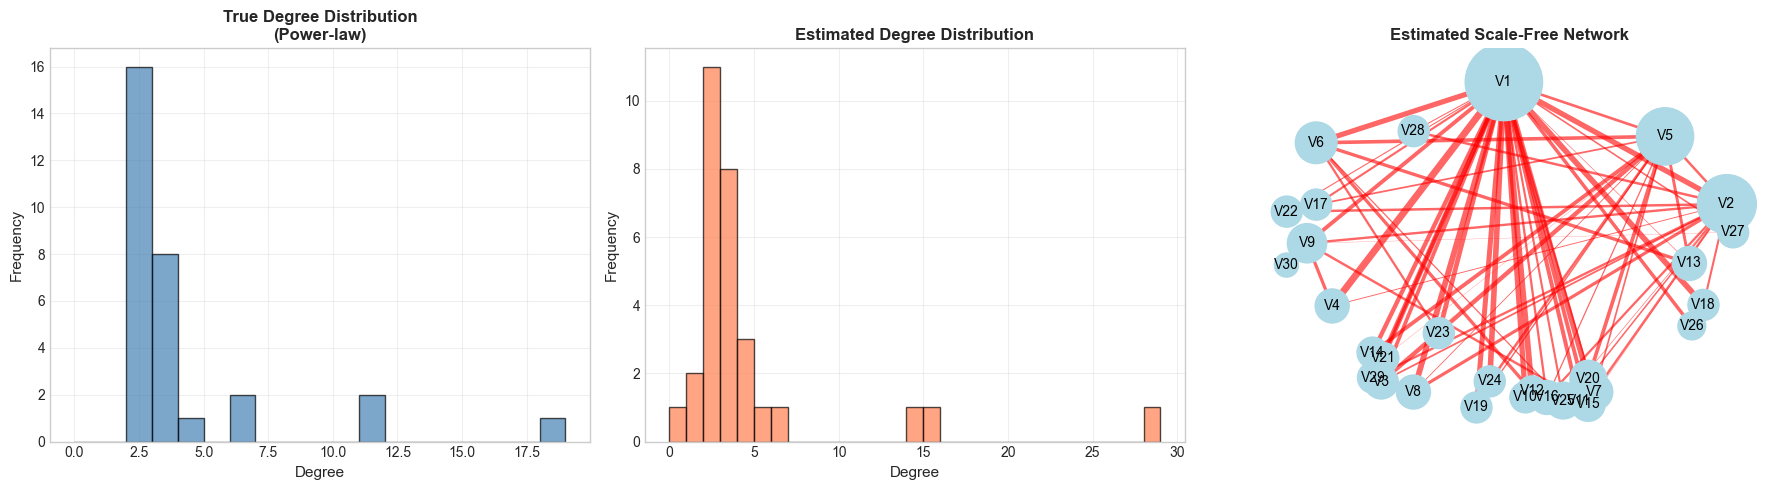


Hub nodes (degree ≥ 5) in true network:
  Node 0: 18 connections
  Node 1: 11 connections
  Node 4: 11 connections
  Node 5: 6 connections
  Node 8: 6 connections


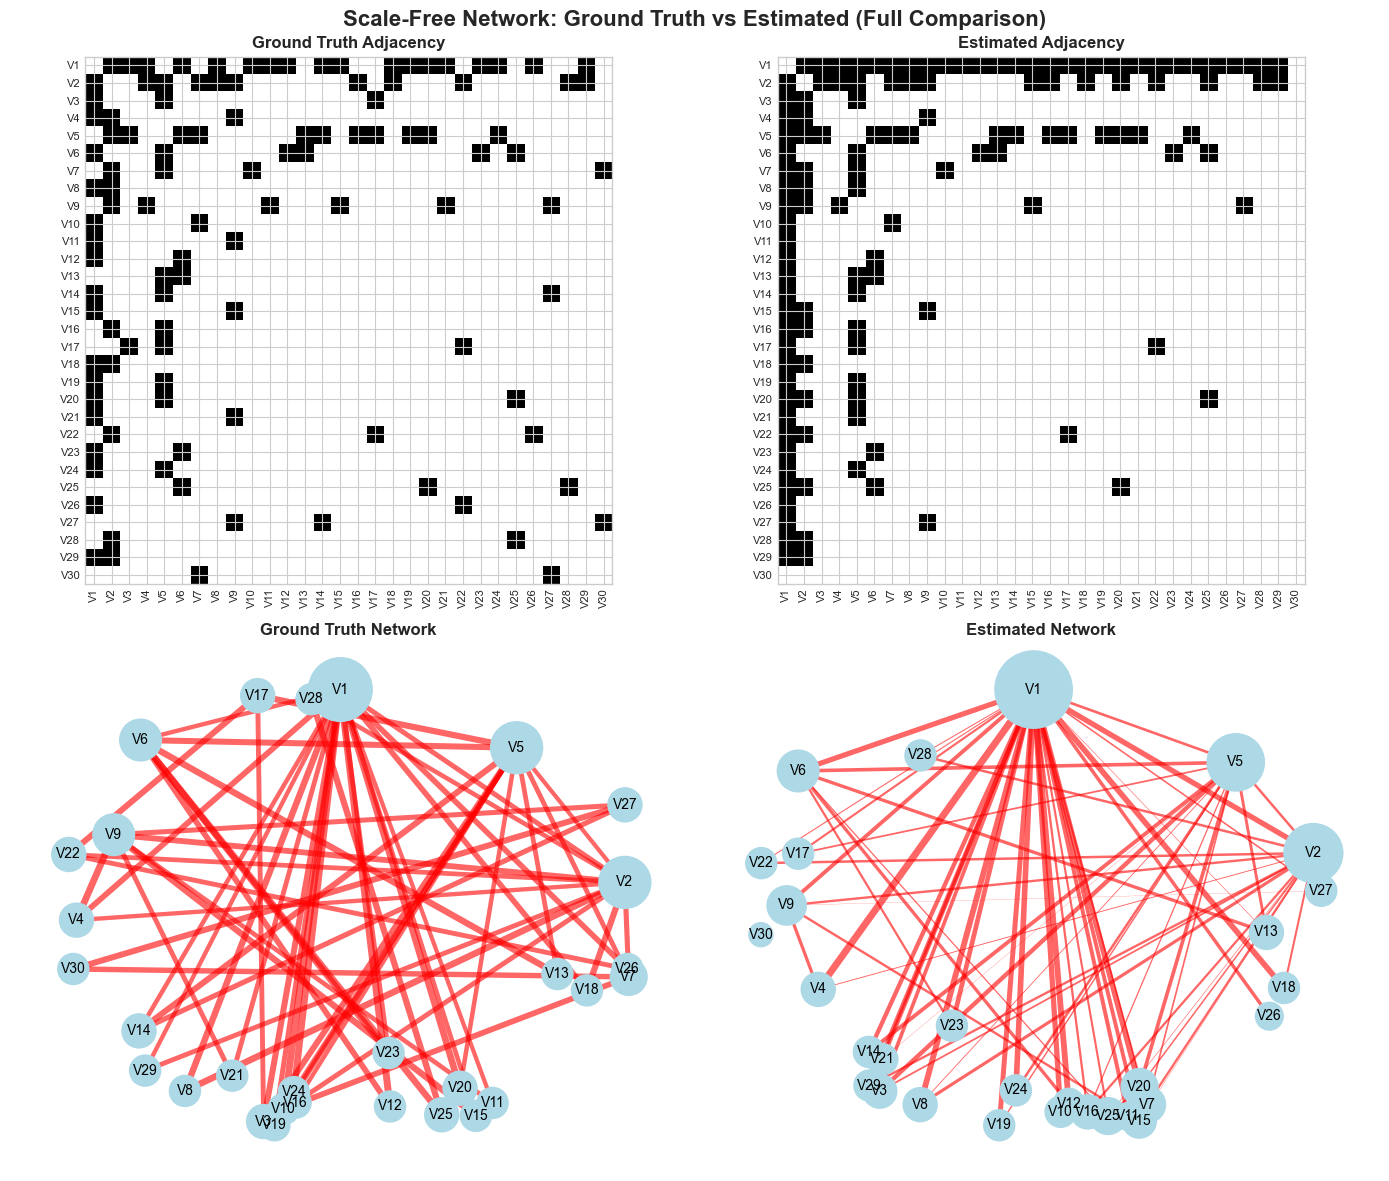

In [7]:
def generate_scale_free_network(n_samples=500, p=30, m=2, edge_strength=0.5):
    """
    Generate scale-free network using Barabási-Albert preferential attachment.
    
    Parameters:
    - p: number of nodes
    - m: number of edges to attach from new node (controls density)
    """
    # Generate scale-free graph structure
    G_sf = nx.barabasi_albert_graph(p, m, seed=42)
    
    # Convert to adjacency matrix
    adj_graph = nx.to_numpy_array(G_sf)
    
    # Create precision matrix from graph structure
    Theta = np.eye(p) * 2.0
    
    # Add edges with random strengths
    for i in range(p):
        for j in range(i + 1, p):
            if adj_graph[i, j] == 1:
                strength = np.random.uniform(-edge_strength, -edge_strength * 0.6)
                Theta[i, j] = strength
                Theta[j, i] = strength
    
    # Ensure positive definite
    min_eig = np.min(np.linalg.eigvalsh(Theta))
    if min_eig < 0.1:
        Theta += np.eye(p) * (0.1 - min_eig)
    
    # Generate data
    Sigma = np.linalg.inv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n_samples)
    
    adjacency = (np.abs(Theta) > 1e-6).astype(int)
    np.fill_diagonal(adjacency, 0)
    
    return X, Theta, adjacency, G_sf

# Generate and fit
X_sf, Theta_sf, adj_sf, G_true_sf = generate_scale_free_network(n_samples=500, p=30, m=2)

model_sf = GaussianGraphicalModel(method='stars', beta=0.05)
model_sf.fit(X_sf)

# Evaluate
precision, recall, f1 = evaluate_recovery(adj_sf, model_sf.adjacency_)

print("Scale-Free Network Recovery")
print("=" * 50)
print(f"True edges:      {adj_sf.sum() // 2}")
print(f"Estimated edges: {model_sf.n_edges_}")
print(f"Precision:       {precision:.3f}")
print(f"Recall:          {recall:.3f}")
print(f"F1-Score:        {f1:.3f}")
print("=" * 50)

# Analyze degree distribution
true_degrees = dict(G_true_sf.degree())
est_G = model_sf.to_networkx()
est_degrees = dict(est_G.degree())

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True degree distribution
degrees_true = list(true_degrees.values())
axes[0].hist(degrees_true, bins=range(max(degrees_true)+2), alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Degree', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('True Degree Distribution\n(Power-law)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Estimated degree distribution
degrees_est = list(est_degrees.values())
axes[1].hist(degrees_est, bins=range(max(degrees_est)+2) if degrees_est else [0,1], 
            alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Degree', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Estimated Degree Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Network visualization
labels_sf = [f'V{i+1}' for i in range(30)]
plot_network(model_sf.precision_, threshold=0.01, layout='spring',
            labels=labels_sf, ax=axes[2])
axes[2].set_title('Estimated Scale-Free Network', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nHub nodes (degree ≥ 5) in true network:")
hubs_true = [(node, deg) for node, deg in true_degrees.items() if deg >= 5]
for node, deg in sorted(hubs_true, key=lambda x: -x[1]):
    print(f"  Node {node}: {deg} connections")

# Also show comparison with adjacency matrices
labels = [f'V{i+1}' for i in range(30)]
plot_comparison(adj_sf, model_sf.adjacency_, Theta_sf, model_sf.precision_,
               'Scale-Free Network: Ground Truth vs Estimated (Full Comparison)', labels=labels)

<a id='regpath'></a>
## Regularization Path Visualization

Understanding how the network evolves as we vary the regularization parameter λ:

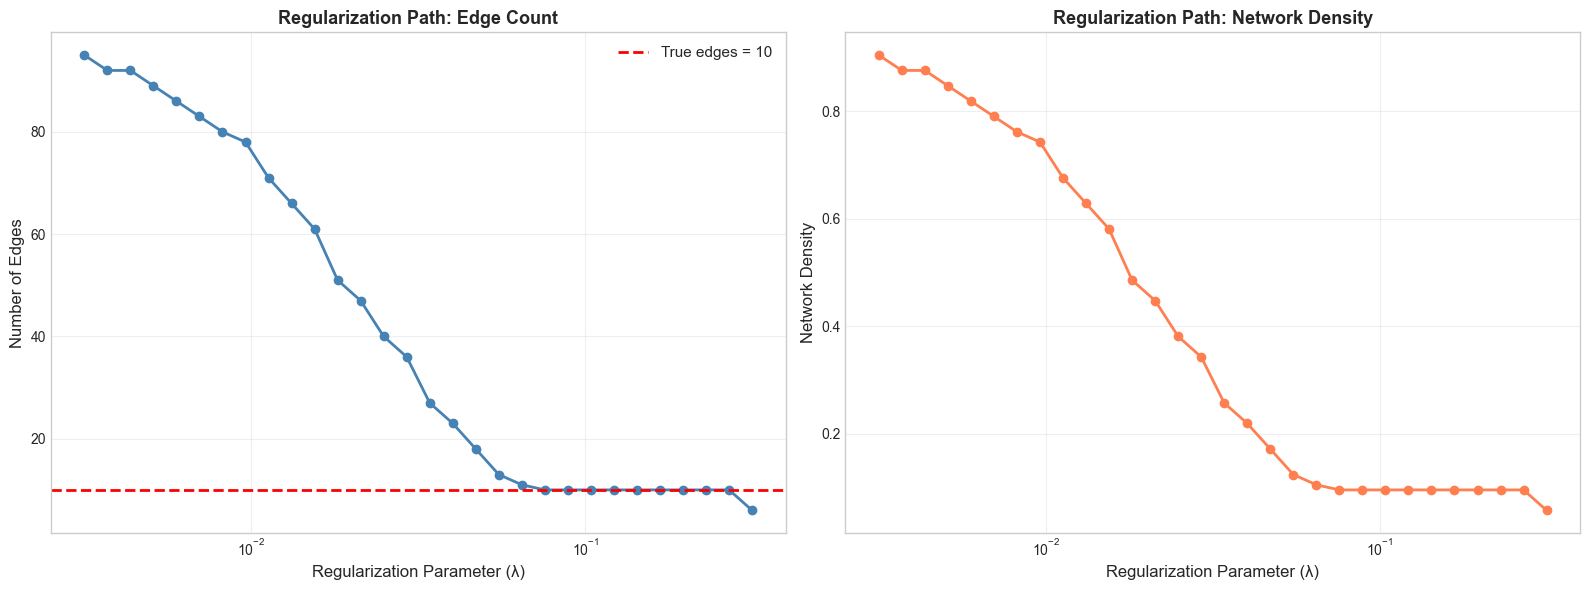


Regularization Path Summary
λ range: 0.0032 to 0.3162
Edge count range: 6 to 95
True edges: 10

Larger λ → sparser network (more regularization)
Smaller λ → denser network (less regularization)


In [10]:
# Generate test data
X_path, Theta_path, adj_path = generate_hub_network(n_samples=500, p=15)

# Create a fine grid of lambda values
from sklearn.covariance import graphical_lasso

# Compute empirical covariance
emp_cov = np.cov(X_path.T)

# Test range of lambda values
lambdas = np.logspace(-2.5, -0.5, 30)
n_edges_path = []
densities = []

for lam in lambdas:
    try:
        _, prec = graphical_lasso(emp_cov, alpha=lam, max_iter=100)
        adj = (np.abs(prec) > 1e-6).astype(int)
        np.fill_diagonal(adj, 0)
        n_edges = adj.sum() // 2
        n_edges_path.append(n_edges)
        densities.append(n_edges / (15 * 14 / 2))  # density
    except:
        n_edges_path.append(0)
        densities.append(0)

# Plot regularization path
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Edge count vs lambda
axes[0].plot(lambdas, n_edges_path, 'o-', linewidth=2, markersize=6, color='steelblue')
axes[0].axhline(adj_path.sum() // 2, color='red', linestyle='--', linewidth=2, 
                label=f'True edges = {adj_path.sum() // 2}')
axes[0].set_xlabel('Regularization Parameter (λ)', fontsize=12)
axes[0].set_ylabel('Number of Edges', fontsize=12)
axes[0].set_title('Regularization Path: Edge Count', fontsize=13, fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Network density vs lambda
axes[1].plot(lambdas, densities, 'o-', linewidth=2, markersize=6, color='coral')
axes[1].set_xlabel('Regularization Parameter (λ)', fontsize=12)
axes[1].set_ylabel('Network Density', fontsize=12)
axes[1].set_title('Regularization Path: Network Density', fontsize=13, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegularization Path Summary")
print("=" * 60)
print(f"λ range: {lambdas.min():.4f} to {lambdas.max():.4f}")
print(f"Edge count range: {min(n_edges_path)} to {max(n_edges_path)}")
print(f"True edges: {adj_path.sum() // 2}")
print("=" * 60)
print("\nLarger λ → sparser network (more regularization)")
print("Smaller λ → denser network (less regularization)")

### Visualize Networks at Different λ Values

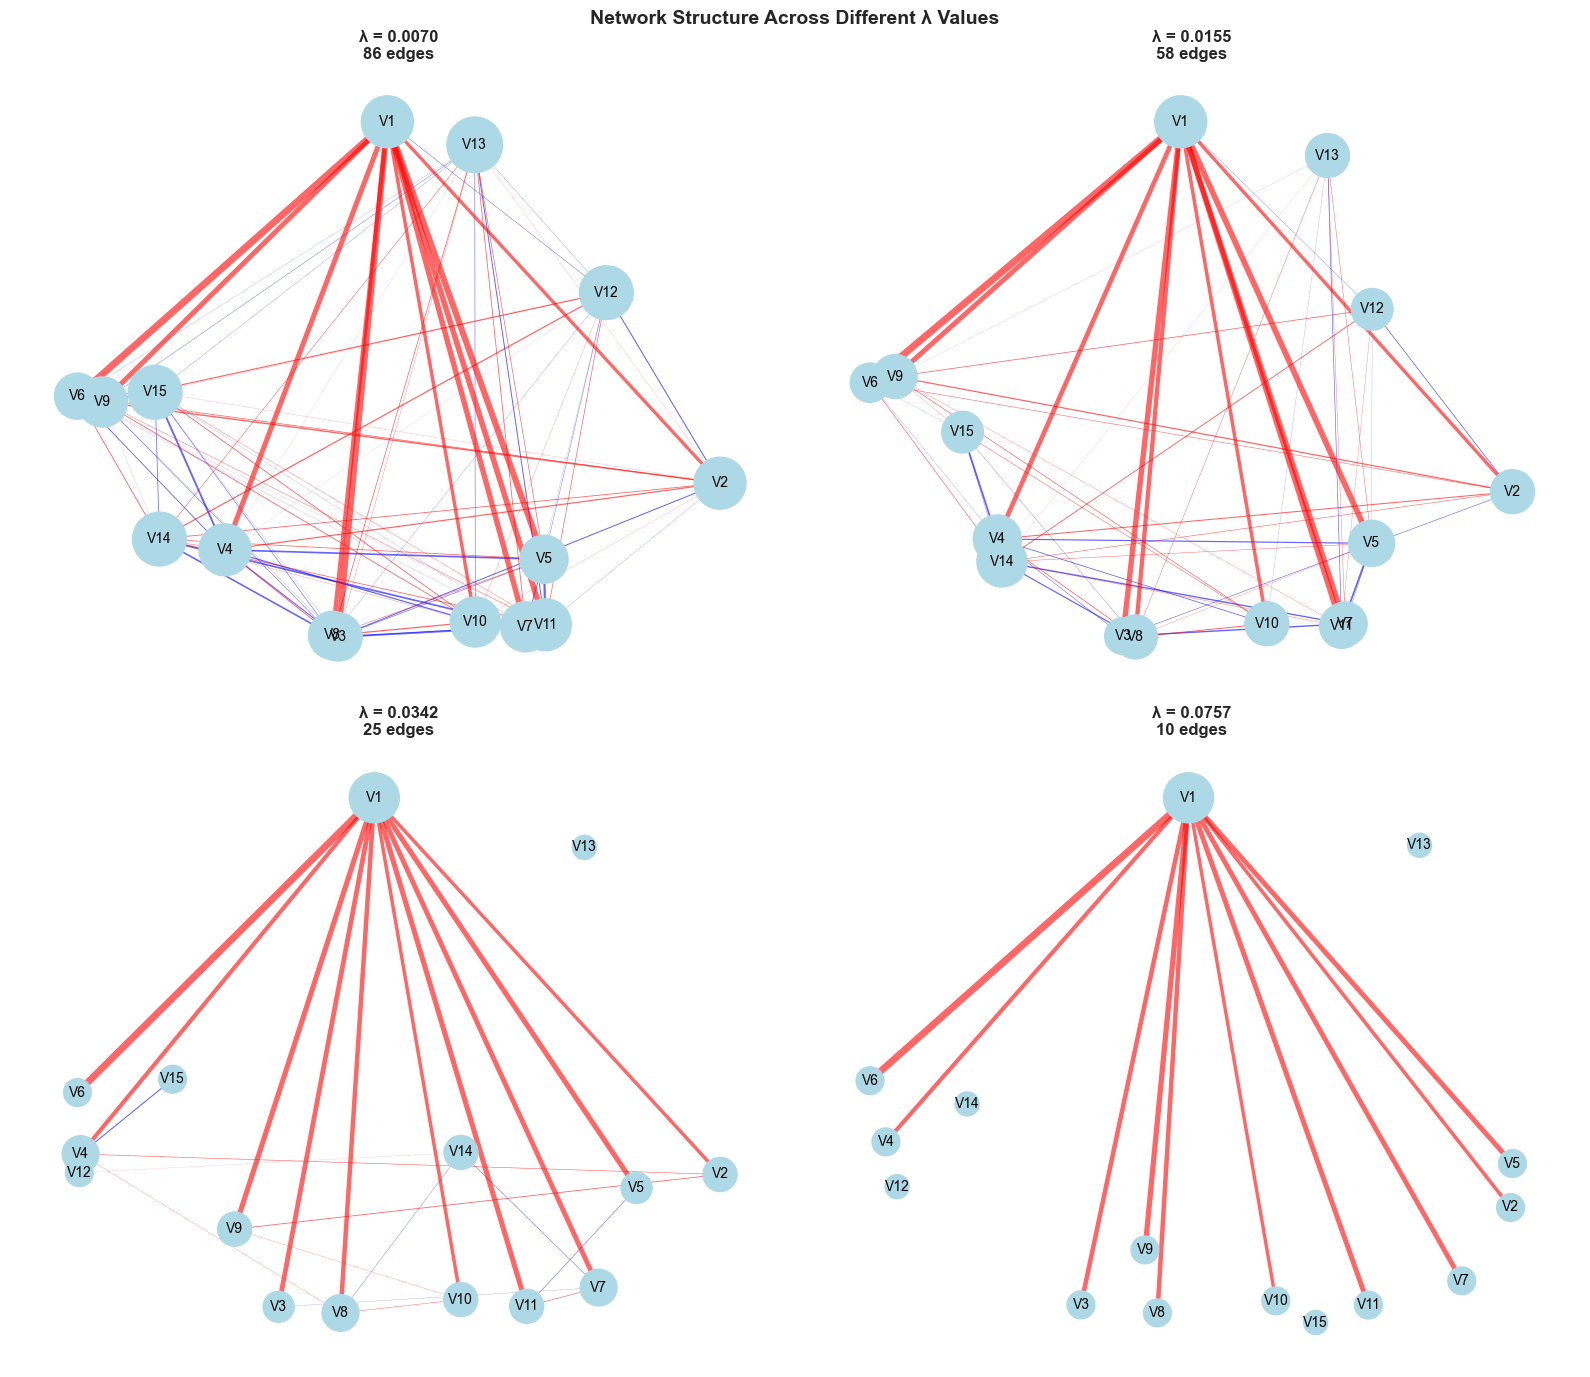

In [9]:
# Show networks at 4 different lambda values
lambda_indices = [5, 10, 15, 20]  # Sparse to dense
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, lam_idx in enumerate(lambda_indices):
    lam = lambdas[lam_idx]
    try:
        _, prec = graphical_lasso(emp_cov, alpha=lam, max_iter=100)
        labels = [f'V{i+1}' for i in range(15)]
        plot_network(prec, threshold=0.01, layout='spring', 
                    labels=labels, ax=axes[idx])
        adj = (np.abs(prec) > 1e-6).astype(int)
        np.fill_diagonal(adj, 0)
        axes[idx].set_title(f'λ = {lam:.4f}\n{adj.sum() // 2} edges', 
                          fontsize=12, fontweight='bold')
    except:
        axes[idx].text(0.5, 0.5, 'Failed to converge', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'λ = {lam:.4f}', fontsize=12, fontweight='bold')

plt.suptitle('Network Structure Across Different λ Values', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()